In [1]:
import requests
from dotenv import load_dotenv
from os import getenv

from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np

import sys
sys.path.append("D:\\projects\\geo_image_experiments\\src")
import importlib
import mapillary_utils as mu
importlib.reload(mu)
import image_processing_utils as ipu
importlib.reload(ipu)


import sqlite3
import json

from datetime import datetime
import uuid

In [2]:
load_dotenv()
API_KEY = getenv("MAPILLARY_CLIENT_TOKEN")
#for saving images
base_dir = "D://projects_working_directories//202408_pano_images//images"
base_dir = "D://projects_working_directories//imagery_analysis//20241130_non_pano_images_for_training//images"

In [7]:
image_id = '1068419173817547'
image_id = '187941237651945'
image_id = '890249353066985'
image_id = '1310060703490860'
image_id = '1031737564608425'

api_key = API_KEY
image, metadata = mu.get_mapillary_image(image_id, api_key, image_size_indicator='thumb_2048_url', image_dir=base_dir)

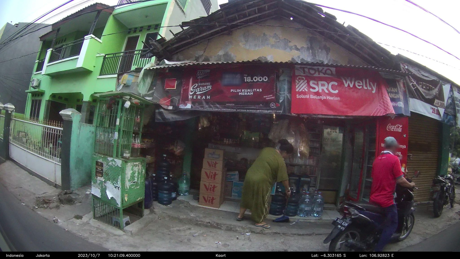

In [4]:
ipu.get_thumbnail(image)

## alternative: iterate over multiple and save

In [27]:
df_foo = pd.read_excel("c://temp//list_of_market.xlsx", sheet_name="Sheet3")
list_of_ids = df_foo.id.tolist()
for image_id in list_of_ids:
    image, metadata = mu.get_mapillary_image(image_id, api_key, image_size_indicator='thumb_2048_url', image_dir=base_dir)

## END

In [85]:
def zz_get_mapillary_imagex(image_id, api_key, image_size_indicator='thumb_2048_url'):
    def generate_uuid():
        return uuid.uuid4().hex
    
    def save_image(image, path):
        image.save(path)
        print(f"Image saved to {path}")
    
    headers = {
        'Authorization': f'OAuth {api_key}'
    }

    
    #url = f'https://graph.mapillary.com/{image_id}?fields=thumb_2048_url,captured_at,geometry,height,width'
    url = f'https://graph.mapillary.com/{image_id}?fields={image_size_indicator},captured_at,geometry,height,width,compass_angle,computed_compass_angle,camera_type,sequence,altitude'
    
     
    
    
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    # Get the image URL and metadata from the response
    data = response.json()
    print(data)
    image_url = data.get(image_size_indicator)
    image_id = data.get('id')
    captured_at = data.get('captured_at')
    geometry = data.get('geometry')
    detections = data.get('detections')
    original_height = data.get('height')
    original_width = data.get('width')
    compass_angle = data.get('compass_angle')
    computed_compass_angle = data.get('computed_compass_angle')
    camera_type = data.get('camera_type')
    sequence = data.get('sequence')
    altitude = data.get('altitude')

    if not image_url:
        print(f"Image URL not found in the response: {image_url}")
        return None, None

    # Download the image
    image_response = requests.get(image_url)
    image_response.raise_for_status()
    image = Image.open(BytesIO(image_response.content))

    save_image_path = f'c:\\temp\\mapillary_{image_id}_{image_size_indicator}.jpg'
    save_image(image, save_image_path)
    
    metadata = {
        'guid' : generate_uuid(),
        'image_source' : 'mapillary',
        'image_id': image_id,
        'captured_at_unix': captured_at,
        'lat' : geometry['coordinates'][0],
        'long' : geometry['coordinates'][1],
        'original_height' : original_height,
        'original_width' : original_width,
        'height' : image.height,
        'width' : image.width,
        'camera_type' : camera_type,
        'compass_angle' : compass_angle,
        'computed_compass_angle' : computed_compass_angle,
        'sequence' : sequence,
        'image_path_on_disk' : save_image_path,
        'altitude' : altitude
        
    }
    return image, metadata



def zz_get_thumbnail(image, prct=0.4):
    """
    Creates a thumbnail of the given image based on the specified percentage of its original dimensions.

    Parameters:
    - image: A PIL Image object. The image to be resized into a thumbnail.
    - prct: float. A percentage (between 0 and 1) that determines the size of the thumbnail relative to the original image dimensions.

    Returns:
    - small_image: A PIL Image object. The thumbnail version of the original image.

    """

    small_image = image.copy()

    small_w = int(image.size[0] * prct)
    small_h = int(image.size[1] * prct)
    #size = (small_h, small_w)
    small_image.thumbnail((small_h, small_w))
    

    return small_image